In [1]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

## Model Class

In [2]:
class CNN_Classification_Model(nn.Module):
    def __init__(self, input_dims, num_classes, learning_rate=1e-04):
        super(CNN_Classification_Model, self).__init__()

        self.input_dims = input_dims
        self.n_classes = n_classes
        
        self.conv = nn.Conv2d(input_dims[0], 32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(2, 2)

        fc_input_dims = self.calculate_fc_input_dims()

        self.fc1 = nn.Linear(fc_input_dims, 256)
        self.fc2 = nn.Linear(256, n_classes)

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, X):
        conv = F.relu(self.conv(X))
        pool = self.pool(conv)
        fc_input = pool.view(pool.shape[0], -1)
        fc1 = F.relu(self.fc1(fc_input))
        fc2 = self.fc2(fc1)
        return F.softmax(fc2, dim=1)


    def calculate_fc_input_dims(self):
        x = T.zeros((1,) + self.input_dims)
        x = self.conv(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        return x.shape[1]
    
    
    def fit(self, X, Y, epochs=1000, print_every=100, batch_size=256):
        
        n_batches = int(np.ceil(X.shape[0]/batch_size))
        val_idx = 0
        
        train_loss_per_epoch = []
        val_loss_per_epoch = []
        
        for epoch in range(epochs):
            
            batch_train_loss = 0
            
            batch_indices = [n for n in range(n_batches)]
            batch_indices.pop(val_idx)
            
            for i in batch_indices:
                Xbatch_train = X[i*batch_size:(i+1)*batch_size]
                Ybatch_train = Y[i*batch_size:(i+1)*batch_size]
            
                self.optimizer.zero_grad()
                Yhat_train = self.forward(Xbatch_train)
                loss = self.loss(Yhat_train, Ybatch_train)
                batch_train_loss += loss.item()
                
                loss.backward()
                self.optimizer.step()
            
            batch_train_loss /= n_batches
            
            Xbatch_val = X[val_idx*batch_size:(val_idx+1)*batch_size]
            Ybatch_val = Y[val_idx*batch_size:(val_idx+1)*batch_size]
            Yhat_val = self.forward(Xbatch_val).detach()
            batch_val_loss = self.loss(Yhat_val, Ybatch_val).detach().item()

            val_idx = (val_idx + 1) % n_batches
            
            train_loss_per_epoch.append(batch_train_loss)
            val_loss_per_epoch.append(batch_val_loss)
            
            if epoch == 0 or (epoch+1) % print_every == 0:
                print(f'[ Epoch: {epoch+1} / {epochs} | Training Loss: {batch_train_loss:.3f}] | Validation Loss: {batch_val_loss:.3f}')

        return train_loss_per_epoch, val_loss_per_epoch
            
    

## Model Training

In [3]:
data = pd.read_csv('DataFiles/mnist_train.csv')

In [4]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
labels = data['label']
rowPics = data.drop(['label'], axis=1)
rowPics = np.array(rowPics)

In [6]:
pictures = []
for i in range(rowPics.shape[0]):
    pic = rowPics[i,:]
    pictures.append(np.reshape(pic, (1, 28, 28)))
pictures = np.array(pictures)
print(pictures.shape)

(60000, 1, 28, 28)


In [7]:
input_dims = pictures[0,:,:].shape
n_classes = len(set(labels[:]))
print(input_dims, n_classes)

(1, 28, 28) 10


In [8]:
model = CNN_Classification_Model(input_dims, n_classes)

In [9]:
X = T.tensor(pictures)/255.
Y = T.LongTensor(labels)

In [10]:
train_losses, val_losses = model.fit(X, Y, epochs=200, print_every=10, batch_size=1024)

[ Epoch: 1 / 200 | Training Loss: 2.110] | Validation Loss: 1.955
[ Epoch: 10 / 200 | Training Loss: 1.522] | Validation Loss: 1.543
[ Epoch: 20 / 200 | Training Loss: 1.489] | Validation Loss: 1.501
[ Epoch: 30 / 200 | Training Loss: 1.475] | Validation Loss: 1.500
[ Epoch: 40 / 200 | Training Loss: 1.466] | Validation Loss: 1.486
[ Epoch: 50 / 200 | Training Loss: 1.460] | Validation Loss: 1.489
[ Epoch: 60 / 200 | Training Loss: 1.456] | Validation Loss: 1.484
[ Epoch: 70 / 200 | Training Loss: 1.454] | Validation Loss: 1.474
[ Epoch: 80 / 200 | Training Loss: 1.451] | Validation Loss: 1.481
[ Epoch: 90 / 200 | Training Loss: 1.449] | Validation Loss: 1.478
[ Epoch: 100 / 200 | Training Loss: 1.448] | Validation Loss: 1.476
[ Epoch: 110 / 200 | Training Loss: 1.447] | Validation Loss: 1.476
[ Epoch: 120 / 200 | Training Loss: 1.446] | Validation Loss: 1.473
[ Epoch: 130 / 200 | Training Loss: 1.445] | Validation Loss: 1.470
[ Epoch: 140 / 200 | Training Loss: 1.444] | Validation Los

In [11]:
T.save(model.state_dict(), 'MNIST_model.pt')

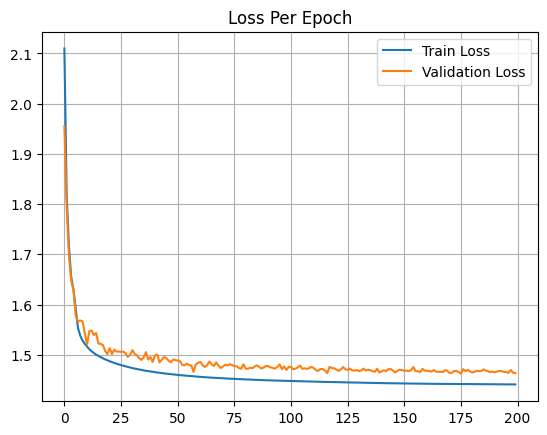

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.grid()
plt.title('Loss Per Epoch')
plt.legend()
plt.show()

## Model Testing

In [14]:
data = pd.read_csv('DataFiles/mnist_test.csv')

In [15]:
labels = data['label']
labels.shape

(10000,)

In [16]:
rowPics = data.drop(['label'], axis=1)
rowPics = np.array(rowPics)

In [17]:
pictures = []
for i in range(rowPics.shape[0]):
    pic = rowPics[i,:]
    pictures.append(np.reshape(pic, (1, 28, 28)))
pictures = np.array(pictures)
pictures.shape

(10000, 1, 28, 28)

In [18]:
X = T.tensor(pictures)/255.
Y = T.LongTensor(labels)

In [19]:
correct_predictions = np.zeros_like(Y)
batch_size = 1024
n_batches = int(np.ceil(X.shape[0]/batch_size))
for i in range(n_batches):
    Xbatch = X[i*batch_size:(i+1)*batch_size]
    Ybatch = Y[i*batch_size:(i+1)*batch_size]
    Yhat = model.forward(Xbatch).detach()
    Yhat = T.argmax(Yhat, axis=1)
    correct_predictions_batch = np.zeros_like(Ybatch)
    correct_predictions_batch[Ybatch == Yhat] = 1
    correct_predictions[i*batch_size:(i+1)*batch_size] = np.copy(correct_predictions_batch)
print(f'Classification Rate on Test Dataset: {np.mean(correct_predictions)*100:.2f}%')

Classification Rate on Test Dataset: 98.31%
